In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from tqdm import tqdm

2023-12-05 13:53:04.729718: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
df = pd.read_csv("../data/clean_job_postings_w_salary.csv")

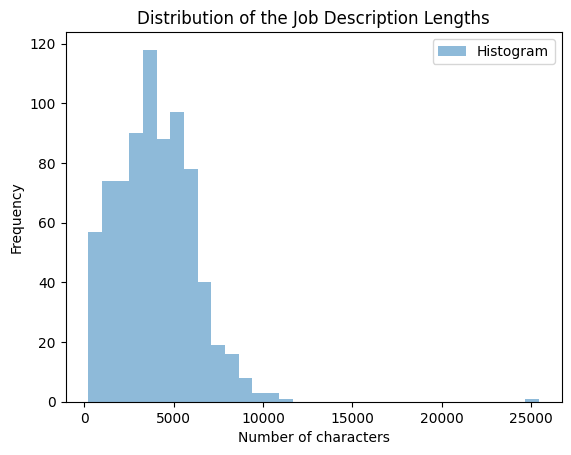

In [5]:
lengths = df['job description'].apply(len)

plt.hist(lengths, bins=33, alpha=0.5, label='Histogram')

#plt.hist(lengths, bins=33, cumulative=True, alpha=0.5, label='Cumulative Histogram')

plt.xlabel("Number of characters")
plt.ylabel("Frequency")
plt.title("Distribution of the Job Description Lengths")
plt.legend()

plt.show()


In [7]:
descriptions = df['job description'].values.tolist()

In [9]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)


def sliding_window_chunks(text, max_length, overlap):
    tokens = tokenizer.tokenize(text)
    chunk_size = max_length - overlap
    chunks = [tokens[i:i + max_length] for i in range(0, len(tokens), chunk_size) if i + max_length <= len(tokens)]
    chunked_texts = [' '.join(chunk) for chunk in chunks]
    return chunked_texts

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2').to('cuda')
model.eval()
batch_size = 128
sentence_embeddings = []
for i in tqdm(range(0, len(descriptions), batch_size), desc="Processing"):
    batch = descriptions[i:i + batch_size]

    encoded_input = tokenizer(batch, padding=True, truncation=True, return_tensors='pt')
    encoded_input = {key: val.to('cuda') for key, val in encoded_input.items()}

    with torch.no_grad():
        model_output = model(**encoded_input)

    batch_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
    batch_embeddings = F.normalize(batch_embeddings, p=2, dim=1)
    batch_embeddings = batch_embeddings.to('cpu').numpy()

    sentence_embeddings.append(batch_embeddings)


    del encoded_input, model_output, batch_embeddings
    torch.cuda.empty_cache()

all_embeddings = np.concatenate(sentence_embeddings, axis=0)
print(all_embeddings.shape)
embeddings = pd.DataFrame(all_embeddings)
embeddings.to_csv("embeddings.csv")

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

AssertionError: Torch not compiled with CUDA enabled

In [ ]:
input_df = pd.concat([df, embeddings], axis=1)

'Microsoft 365 is a key part of the company’s cloud strategy and overall mission of empowering people and organizations to achieve more. As part of the customer journey to the cloud there are times when they need to reach out to seek help from Microsoft and that’s where our team steps in to make sure that the customer support experience is best in class. Our team is responsible for the entire admin and support ecosystem starting from the Microsoft admin portal (https://admin.microsoft.com), support entry point experience, AI driven self-help, diagnostics and making sure telemetry is readily available to all of engineering to continuously drive product improvements. Our team is full of people who have truly embraced a growth mindset, is not afraid to make mistakes, believes in doing and are obsessed about providing our customers the best support experience possible.\n\nThe data science team is engaged in building intelligent solutions using AI and ML that help in resolving customer issu